In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.5/442.5 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 10.9 MB/s eta 0:00:00
Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (122/122), done.
remot

---

In [1]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [2]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-2-151b9d639ad9>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [4]:
# setup model configurations
config = {
    # general information
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "BiLSTM",
    "sem-space": 'I3D',
    # model training configs
    "lr": 0.001,
    "imu_alpha": 0.001,
    "n_epochs": 50,
    "batch_size": 64,
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 400, # skel-AE hidden size and IMU-Anc output size
    "semantic_size": 400,
    # dataset configs
    "window_size": 5.21, 
    "overlap": 4.21,
    "freq": 20,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.1,
}

In [5]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [6]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2ReaderV2(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [7]:
def read_I3D_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

In [8]:
# load video dataset
I3D_data_path  = data_root + '/I3D/video_feat.pkl'
video_data = read_I3D_pkl(I3D_data_path, feat_size="400")
video_classes, attr_mat = video_data['activity'], video_data['features']

In [9]:
# re-arrange semantic space
activity_dict = dict(zip(video_classes, attr_mat))
semantic_space = np.array([activity_dict[c] for c in actionList])

In [10]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        y_feat = self.attributes[target, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = self.attributes[self.action_classes, ...]
        return cls_feat

In [11]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        out = self.sigmoid(out)
        # out = self.fcLayer2(out)
        return out

---

In [12]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [14]:
def loss_cross_entropy(y_pred, y, feat, loss_fn=nn.CrossEntropyLoss(reduction="mean")):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    return output

def tripletLoss(pred_feat, y, feats, loss_fn=nn.TripletMarginLoss(margin=0.1, p=2)):
    pos_feats = feats[y].unsqueeze(1)
    anchor_feat = pred_feat.unsqueeze(1)
    index_2d = [torch.arange(config['batch_size']), y]
    batch_feats = feats.unsqueeze(0).repeat(config['batch_size'], 1, 1)
    neg_feats = batch_feats.index_put(indices=index_2d, values=torch.tensor(2.))
    # print(pos_feats.shape, anchor_feat.shape, neg_feats.shape)
    output = loss_fn(anchor_feat, pos_feats, neg_feats)
    return output


def predict_class(y_pred, selected_features):

    num_classes = selected_features.size()[0]

    cosine_sim_comb = []
    for entry in y_pred.unbind():
        cosine_sim = torch.argmax(F.softmax(torch.abs(F.cosine_similarity(entry.repeat(num_classes,1),selected_features)),dim=-1))
        cosine_sim_comb.append(cosine_sim)

    pred = torch.stack(cosine_sim_comb)
    return pred

In [15]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output, targets.squeeze(), random_selected_feat, loss_fn =loss_module['class'] )
                feat_loss = tripletLoss(feat_output, targets.squeeze(), random_selected_feat, loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output, random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [16]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=True, show_plot=False, loss_alpha=0.7):
    model = model.eval()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output, targets.squeeze(), random_selected_feat, loss_fn =loss_module['class'] )
                feat_loss = tripletLoss(feat_output, targets.squeeze(), random_selected_feat, loss_fn=loss_module["feature"])
            
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output, random_selected_feat)

            # convert feature vector into action class using cosine
            if phase == 'seen':
                pred_action = class_output
            else:
                #feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                #action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [17]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [18]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [19]:
run = neptune.init_run(
    project="FYP-Group22/ICANN-Logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

<ipython-input-19-0fd58e113600>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-52


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.277



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.466



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.571



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.565



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.640



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.684



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.721



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.712



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.722



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.746



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.698



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.744



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.748



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.778



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.773



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.770



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.783



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.786



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.783



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.779



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.619



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.790



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.779



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.780



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.787



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.790



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.790



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.765



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.790



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.790



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.796



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.748



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.788



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.796



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.696



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.792



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.792



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.796



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.793



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.798



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.796



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.794



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.793



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.805



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.744



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.789



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.769



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.802



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.796



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.803



unseen:   0%|          | 0/87 [00:00<?, ?batch/s]

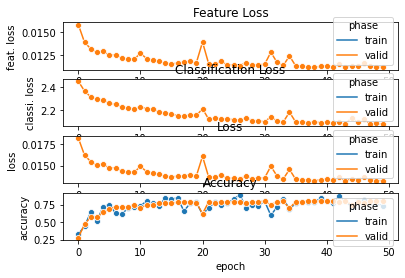

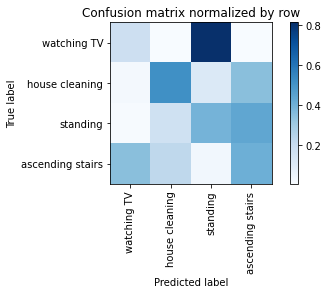

Overall accuracy: 0.402

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.438      0.388      0.411      0.330       1840|	 ascending stairs: 0.436,	house cleaning: 0.167,	
  house cleaning       0.632      0.517      0.569      0.328       1828|	 ascending stairs: 0.348,	standing: 0.115,	
ascending stairs       0.231      0.404      0.294      0.193       1073|	 watching TV: 0.348,	house cleaning: 0.223,	
     watching TV       0.257      0.178      0.210      0.149        827|	 standing: 0.815,	ascending stairs: 0.004,	

----------------------------------------------------------------------------------------------------
     avg / total       0.435      0.402      0.411        1.0       5568|	      

{'accuracy': 0.4019396551724138, 'precision': 0.3897149313146332, 'recall': 0.3714377009767576, 'f1': 0.37103693412560657, 'samples': 5568, 'loss': 174.9905686378479, 'feat. loss': 174.30977749824524, 'classi. loss': 680

Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.282



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.299



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.375



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.463



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.507



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.532



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.573



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.625



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.604



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.620



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.641



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.678



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.706



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.594



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.644



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.698



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.718



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.729



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.740



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.722



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.700



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.746



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.729



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.781



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.761



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.753



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.780



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.799



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.764



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.839



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.866



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.840



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.866



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.857



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.828



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.861



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.868



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.840



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.892



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.866



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.863



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.846



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.860



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.836



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.882



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.892



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.873



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.884



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.872



train:   0%|          | 0/295 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.894



unseen:   0%|          | 0/86 [00:00<?, ?batch/s]

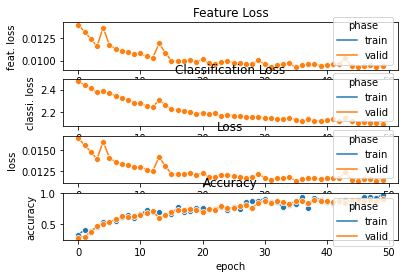

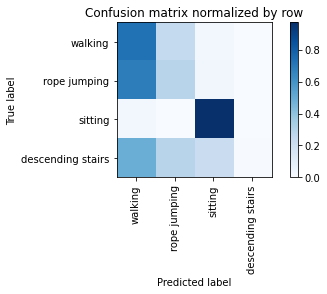

Overall accuracy: 0.644

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.671      0.724      0.696      0.420       2314|	 rope jumping: 0.247,	sitting: 0.029,	
          sitting       0.857      0.970      0.910      0.325       1788|	 walking: 0.029,	rope jumping: 0.001,	
descending stairs       1.000      0.005      0.011      0.172        946|	 walking: 0.488,	rope jumping: 0.286,	sitting: 0.220,	
     rope jumping       0.134      0.287      0.183      0.083        456|	 walking: 0.680,	sitting: 0.033,	

----------------------------------------------------------------------------------------------------
      avg / total       0.743      0.644      0.605        1.0       5504|	      

{'accuracy': 0.6444404069767442, 'precision': 0.6654543412806718, 'recall': 0.4968027512142611, 'f1': 0.45002392573212474, 'samples': 5504, 'loss': 192.28436756134033, 'feat. loss': 191.67057013511658, 'classi. loss': 6137.9760894

Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.228



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.314



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.390



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.457



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.449



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.494



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.494



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.495



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.490



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.526



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.596



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.555



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.654



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.591



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.611



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.657



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.572



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.590



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.671



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.669



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.684



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.618



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.658



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.634



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.678



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.702



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.647



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.691



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.705



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.693



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.655



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.685



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.703



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.695



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.714



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.708



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.720



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.703



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.681



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.703



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.710



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.699



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.655



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.713



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.711



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.693



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.719



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.715



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.713



train:   0%|          | 0/273 [00:00<?, ?batch/s]

seen:   0%|          | 0/30 [00:00<?, ?batch/s]

Overall accuracy: 0.701



unseen:   0%|          | 0/111 [00:00<?, ?batch/s]

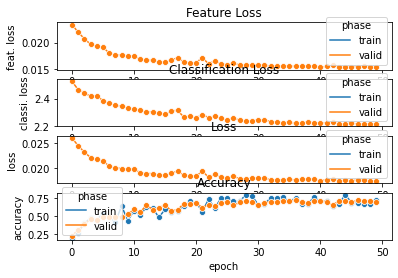

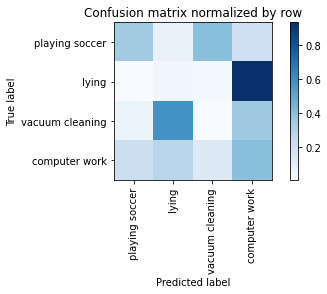

Overall accuracy: 0.205

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.334      0.398      0.363      0.432       3066|	 lying: 0.273,	playing soccer: 0.205,	
          lying       0.035      0.036      0.036      0.264       1876|	 computer work: 0.934,	vacuum cleaning: 0.026,	
vacuum cleaning       0.015      0.005      0.008      0.240       1705|	 lying: 0.584,	computer work: 0.349,	playing soccer: 0.062,	
 playing soccer       0.173      0.339      0.229      0.064        457|	 vacuum cleaning: 0.398,	computer work: 0.195,	

----------------------------------------------------------------------------------------------------
    avg / total       0.168      0.205      0.183        1.0       7104|	      

{'accuracy': 0.20453265765765766, 'precision': 0.13910823512317128, 'recall': 0.19473329120928823, 'f1': 0.15891272245749838, 'samples': 7104, 'loss': 165.300595164299, 'feat. loss': 164.34169745445251, 'classi. l

Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.260



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.289



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.300



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.491



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.399



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.540



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.557



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.551



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.536



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.523



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.574



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.566



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.585



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.602



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.654



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.649



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.660



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.648



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.654



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.640



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.666



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.658



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.688



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.713



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.734



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.797



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.790



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.648



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.817



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.810



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.807



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.781



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.811



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.682



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.698



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.666



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.783



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.785



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.824



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.802



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.778



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.774



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.779



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.830



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.828



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.829



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.828



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.797



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.802



train:   0%|          | 0/311 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.820



unseen:   0%|          | 0/68 [00:00<?, ?batch/s]

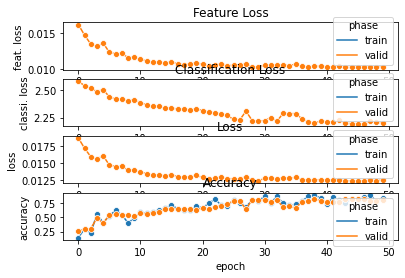

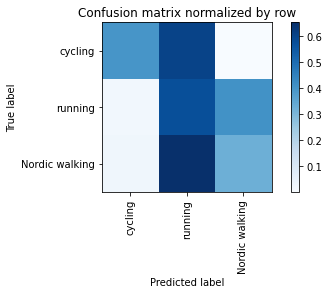

Overall accuracy: 0.403

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.604      0.323      0.421      0.418       1817|	 running: 0.651,	cycling: 0.026,	
       cycling       0.904      0.396      0.551      0.367       1597|	 running: 0.602,	Nordic walking: 0.002,	
       running       0.201      0.574      0.297      0.216        938|	 Nordic walking: 0.406,	cycling: 0.020,	

----------------------------------------------------------------------------------------------------
   avg / total       0.627      0.403      0.442        1.0       4352|	      

{'accuracy': 0.40349264705882354, 'precision': 0.5695980997560391, 'recall': 0.43060413837715455, 'f1': 0.4227339969256338, 'samples': 4352, 'loss': 316.02554512023926, 'feat. loss': 315.5421209335327, 'classi. loss': 4834.259315490723}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1, 2, 3, 4

Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.271



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.312



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.358



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.398



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.497



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.558



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.596



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.593



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.586



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.560



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.562



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.644



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.612



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.599



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.637



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.626



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.675



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.646



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.636



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.675



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.659



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.693



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.670



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.686



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.680



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.685



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.685



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.675



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.681



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.564



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.688



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.729



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.664



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.704



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.689



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.706



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.704



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.717



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.675



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.707



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.692



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.723



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.729



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.736



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.746



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.768



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.768



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.720



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.676



train:   0%|          | 0/319 [00:00<?, ?batch/s]

seen:   0%|          | 0/35 [00:00<?, ?batch/s]

Overall accuracy: 0.729



unseen:   0%|          | 0/60 [00:00<?, ?batch/s]

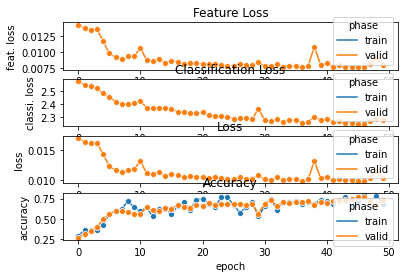

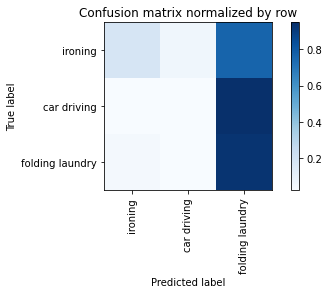

Overall accuracy: 0.348

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.883      0.178      0.296      0.607       2331|	 folding laundry: 0.763,	car driving: 0.059,	
folding laundry       0.284      0.933      0.436      0.253        973|	 ironing: 0.042,	car driving: 0.025,	
    car driving       0.080      0.026      0.039      0.140        536|	 folding laundry: 0.948,	ironing: 0.026,	

----------------------------------------------------------------------------------------------------
    avg / total       0.619      0.348      0.296        1.0       3840|	      

{'accuracy': 0.34817708333333336, 'precision': 0.41560240287741324, 'recall': 0.3791169603743425, 'f1': 0.25715124005456097, 'samples': 3840, 'loss': 350.1328945159912, 'feat. loss': 349.7161445617676, 'classi. loss': 4167.478370666504}
============== Overall Unseen Classes Performance ==============
accuracy           0.400516
precision          0.43589

In [20]:
# run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=0.8, window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['freq'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=semantic_space, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=semantic_space, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=semantic_space, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.TripletMarginLoss(margin=0.15, p=2)}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=config['imu_alpha'])
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=config['imu_alpha'], print_report=False, show_plot=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        log(i, 'valid', train_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    # save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=True, show_plot=True)
    fold_metric_scores.append(test_metrics)
    log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
print(seen_score_df.mean())
log('global', '',seen_score_df.mean().to_dict())
run.stop()
